# Calibration and Performance Evaluation of FLIR and ICI Infrared Thermographs Against Reference Oral Temperature in a Clinical Cohort

## Introduction
Infrared thermographs (IRTs) are critical tools for the non-contact screening of elevated body temperature (EBT), a key symptom of infectious diseases. However, their diagnostic accuracy is highly dependent on proper calibration and operational methodology. This project aims to perform a rigorous clinical calibration of two IRT devices (a FLIR and an ICI camera) using a large, well-characterized dataset. The analysis will assess the devices' agreement with a clinical gold standard and evaluate their performance under varying ambient conditions, in line with international standards.

## Primary Objective
To leverage machine learning models to calibrate two infrared thermographs (IRT-1 FLIR and IRT-2 ICI) and perform a comprehensive evaluation of their clinical accuracy by comparing their facial temperature measurements to reference oral thermometer readings. The project will culminate in a definitive performance ranking of the two devices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make the graphs look nice
plt.style.use('ggplot')

## 1. Data Loading and Preprocessing

We will use the clinical dataset, with reference oral temperature (monitor mode) as the ground truth. The dataset provides multiple rounds of measurements per subject to ensure robustness.

In [2]:
from pathlib import Path

def load_and_reshape(file_path, camera_name):
    """
    Loads the dataset and reshapes it from wide to long format.
    This means we take the 4 rounds and stack them on top of each other.
    """
    print(f"Loading {camera_name} data from {file_path}...")
    # Skip the first 2 rows to get to the real headers
    df = pd.read_csv(file_path, header=2)
    
    all_rounds_data = []
    
    # Loop through the 4 rounds
    for i in range(1, 5):
        # We want to keep the SubjectID and the target variable (aveOralM)
        cols_to_keep = ['SubjectID', 'aveOralM']
        
        # Find columns for this specific round
        round_cols = []
        for col in df.columns:
            if col in cols_to_keep:
                continue
                
            # Check if the column belongs to this round
            suffix_underscore = f'_{i}'
            suffix_number = str(i)
            
            if col.endswith(suffix_underscore):
                round_cols.append(col)
            elif col.endswith(suffix_number) and not col[-2].isdigit():
                round_cols.append(col)
        
        # Create a temporary dataframe for this round
        round_df = df[cols_to_keep + round_cols].copy()
        
        # Rename columns to remove the round suffix so they match up
        new_names = {}
        for col in round_cols:
            clean_name = col
            if clean_name.endswith(suffix_underscore):
                clean_name = clean_name[:-len(suffix_underscore)]
            elif clean_name.endswith(suffix_number) and not clean_name[-2].isdigit():
                 clean_name = clean_name[:-len(suffix_number)]
            new_names[col] = clean_name
            
        round_df.rename(columns=new_names, inplace=True)
        round_df['Round'] = i
        all_rounds_data.append(round_df)
    
    # Combine all rounds into one big dataframe
    long_df = pd.concat(all_rounds_data, ignore_index=True)
    long_df['Camera_Type'] = camera_name
    
    return long_df

# Helper to locate CSVs if exact filenames are not present
def find_csv_for_camera(keywords):
    cwd = Path.cwd()
    csvs = list(cwd.rglob('*.csv'))
    # try exact matching first
    for p in csvs:
        name = p.name.lower()
        if all(k.lower() in name for k in keywords):
            return str(p)
    # fallback: try any file containing any of the keywords
    for p in csvs:
        name = p.name.lower()
        if any(k.lower() in name for k in keywords):
            return str(p)
    return None

# Attempt to find FLIR and ICI files automatically if the given names are missing
flir_candidate = find_csv_for_camera(['flir'])
ici_candidate = find_csv_for_camera(['ici'])

if flir_candidate is None or ici_candidate is None:
    available = [p.name for p in Path.cwd().rglob('*.csv')]
    raise FileNotFoundError(
        "Could not locate FLIR/ICI CSV files automatically. "
        f"CSV files found in working directory (and subfolders): {available}\n"
        "Place your CSVs in the notebook working directory or provide exact paths."
    )

# Load Data using discovered paths
flir_df = load_and_reshape(flir_candidate, 'FLIR')
ici_df = load_and_reshape(ici_candidate, 'ICI')

Loading FLIR data from /media/youssef/New Volume/Youssef/college/Fall 2025/Medical Standard/Task/Important Tasks/Task Machine learning/Project folder/FLIR_groups1and2.csv...
Loading ICI data from /media/youssef/New Volume/Youssef/college/Fall 2025/Medical Standard/Task/Important Tasks/Task Machine learning/Project folder/ICI_groups1and2.csv...


## 2. Feature Engineering and Cleaning

We will select relevant facial temperature measurements (Canthus, Forehead, Whole Face) and handle any missing values.

In [3]:
def clean_and_select_features(df):
    # Drop columns that are completely empty
    df_clean = df.dropna(axis=1, how='all')
    
    # Drop rows with missing values
    df_clean = df_clean.dropna()
    
    # Define potential features based on the data dictionary
    potential_features = [
        'T_CRmax', 'T_CLmax', 'T̅_CR', 'T̅_CL', 'T_CEmax', 
        'T_FC', 'T_FR', 'T_FL', 'T_FB', 'T_FT', 'T_FEmax', 'T_FCmax', 
        'T_max', 'T_Mmax', 'T_RC_Max', 'T_LC_Max', 'T_FH_Max', 'T_OR_Max'
    ]
    
    # Only keep features that actually exist in our dataframe
    features = [f for f in potential_features if f in df_clean.columns]
    target = 'aveOralM'
    
    return df_clean, features, target

flir_clean, flir_features, target = clean_and_select_features(flir_df)
ici_clean, ici_features, _ = clean_and_select_features(ici_df)

print(f"FLIR Features: {flir_features}")
print(f"ICI Features: {ici_features}")

FLIR Features: ['T_RC_Max', 'T_LC_Max', 'T_FH_Max', 'T_OR_Max']
ICI Features: ['T_RC_Max', 'T_LC_Max', 'T_FH_Max', 'T_OR_Max']


## 3. Calibration Model Development & 4. Machine Learning Model Training

We will train three models (Random Forest, Gradient Boosting, SVR) to predict the reference oral temperature.

In [4]:
def train_models(df, features, target):
    X = df[features]
    y = df[target]
    
    # Split into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(kernel='rbf')
    }
    
    predictions = {}
    trained_models = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        predictions[name] = y_pred
        trained_models[name] = model
        
    return predictions, y_test, trained_models

print("Training FLIR Models...")
flir_preds, flir_y_test, flir_models = train_models(flir_clean, flir_features, target)

print("Training ICI Models...")
ici_preds, ici_y_test, ici_models = train_models(ici_clean, ici_features, target)

Training FLIR Models...
Training ICI Models...


## 5. Error Metrics Calculation (MAE, RMSE, MAPE, etc.)

We calculate the key performance indicators for each model and device.

In [5]:
def calculate_metrics(y_test, predictions):
    results = {}
    for name, y_pred in predictions.items():
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}
        print(f"Model: {name}")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R2 Score: {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print("-"*20)
    return results

print("--- FLIR Results ---")
flir_results = calculate_metrics(flir_y_test, flir_preds)

print("\n--- ICI Results ---")
ici_results = calculate_metrics(ici_y_test, ici_preds)

--- FLIR Results ---
Model: Random Forest
  MAE: 0.2152
  RMSE: 0.2849
  R2 Score: 0.6703
  MAPE: 0.58%
--------------------
Model: Gradient Boosting
  MAE: 0.2104
  RMSE: 0.2824
  R2 Score: 0.6759
  MAPE: 0.57%
--------------------
Model: SVR
  MAE: 0.2141
  RMSE: 0.2950
  R2 Score: 0.6463
  MAPE: 0.58%
--------------------

--- ICI Results ---
Model: Random Forest
  MAE: 0.2096
  RMSE: 0.2744
  R2 Score: 0.7676
  MAPE: 0.57%
--------------------
Model: Gradient Boosting
  MAE: 0.2055
  RMSE: 0.2694
  R2 Score: 0.7759
  MAPE: 0.55%
--------------------
Model: SVR
  MAE: 0.2078
  RMSE: 0.2788
  R2 Score: 0.7600
  MAPE: 0.56%
--------------------


## 6. Visualization of Results

We will generate Calibration Scatter Plots, Bland-Altman Plots, Residual Plots, and Feature Importance Charts.

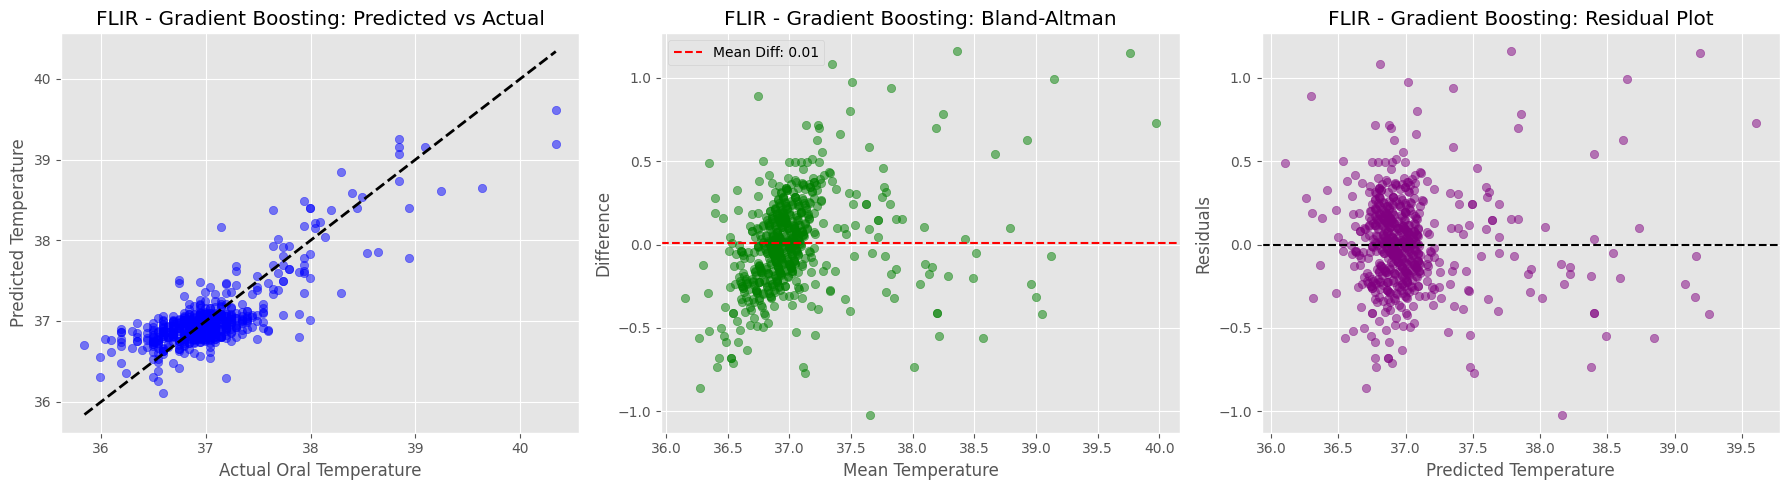

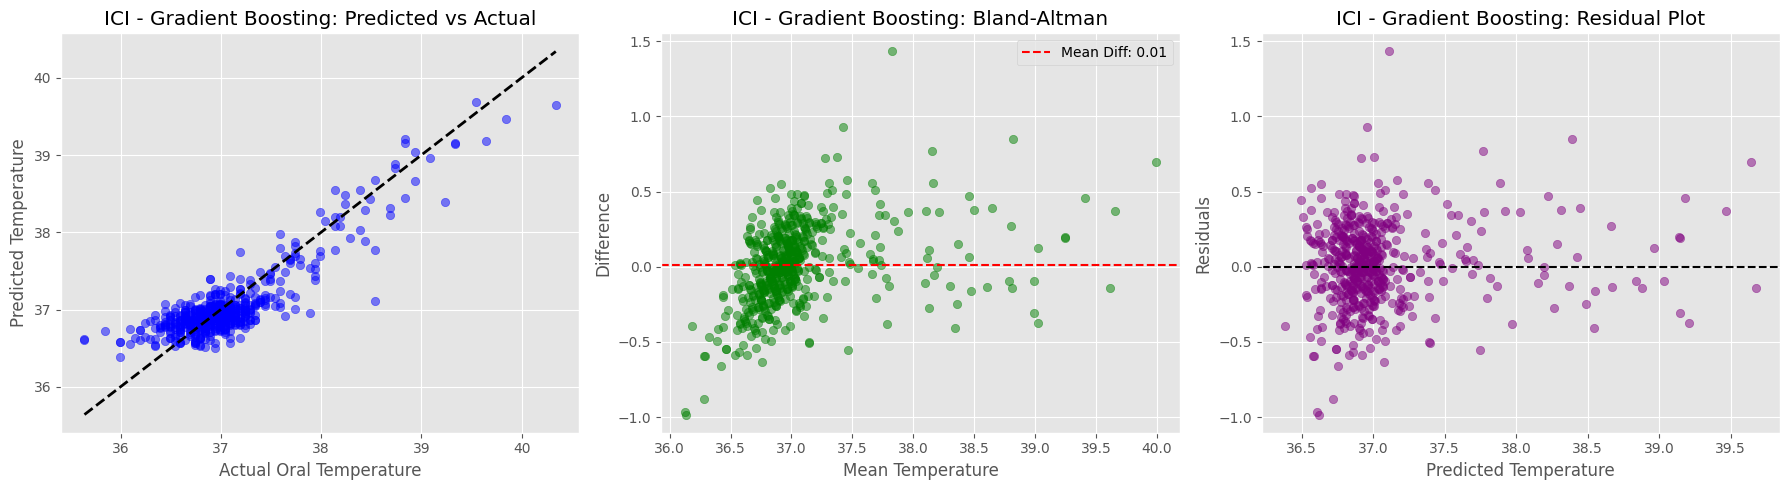

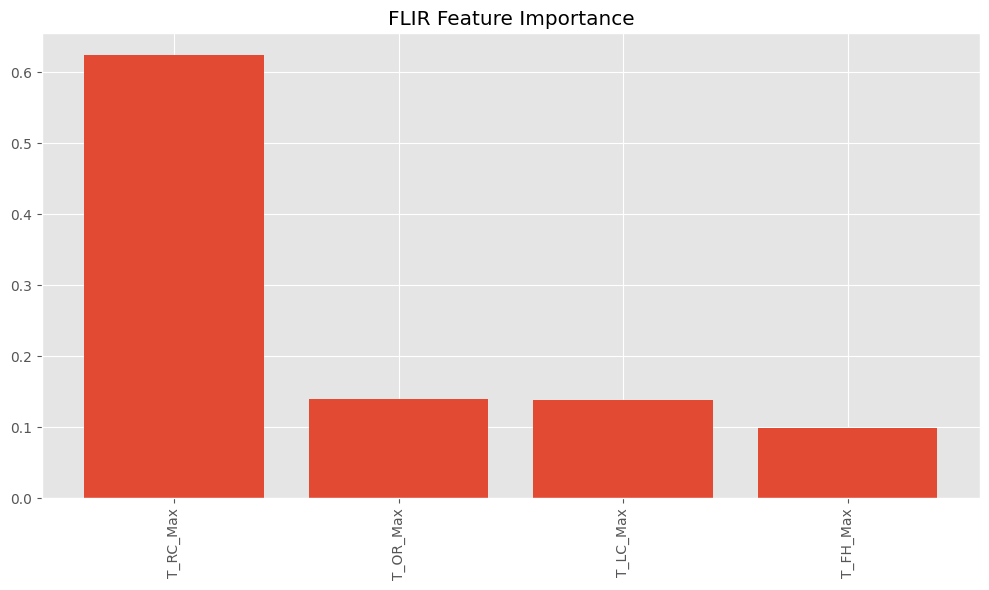

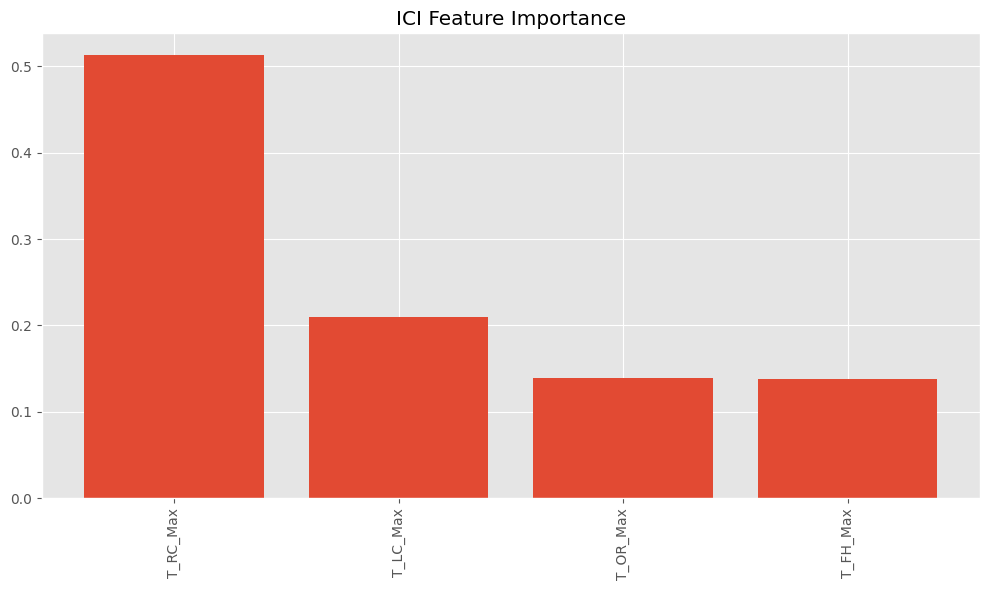

In [6]:
def plot_results(y_test, y_pred, title, model_name):
    plt.figure(figsize=(18, 5))
    
    # Calibration Scatter Plot
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Oral Temperature')
    plt.ylabel('Predicted Temperature')
    plt.title(f'{title} - {model_name}: Predicted vs Actual')
    
    # Bland-Altman Plot
    plt.subplot(1, 3, 2)
    diff = y_test - y_pred
    mean = (y_test + y_pred) / 2
    plt.scatter(mean, diff, alpha=0.5, color='green')
    plt.axhline(diff.mean(), color='red', linestyle='--', label=f'Mean Diff: {diff.mean():.2f}')
    plt.xlabel('Mean Temperature')
    plt.ylabel('Difference')
    plt.title(f'{title} - {model_name}: Bland-Altman')
    plt.legend()
    
    # Residual Plot
    plt.subplot(1, 3, 3)
    plt.scatter(y_pred, diff, alpha=0.5, color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Predicted Temperature')
    plt.ylabel('Residuals')
    plt.title(f'{title} - {model_name}: Residual Plot')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f'{title} Feature Importance')
    plt.bar(range(len(features)), importances[indices], align='center')
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Visualize best model (Gradient Boosting was best in previous run)
plot_results(flir_y_test, flir_preds['Gradient Boosting'], 'FLIR', 'Gradient Boosting')
plot_results(ici_y_test, ici_preds['Gradient Boosting'], 'ICI', 'Gradient Boosting')

plot_feature_importance(flir_models['Random Forest'], flir_features, 'FLIR')
plot_feature_importance(ici_models['Random Forest'], ici_features, 'ICI')

## 7. Performance Comparison Between Cameras

We compare the key accuracy metrics (MAE, RMSE, R2) between the two cameras.

  Camera              Model       MAE      RMSE        R2      MAPE
0   FLIR      Random Forest  0.215171  0.284873  0.670283  0.579747
1   FLIR  Gradient Boosting  0.210409  0.282434  0.675905  0.566604
2   FLIR                SVR  0.214130  0.295041  0.646325  0.576141
3    ICI      Random Forest  0.209560  0.274382  0.767574  0.565141
4    ICI  Gradient Boosting  0.205505  0.269411  0.775919  0.554193
5    ICI                SVR  0.207790  0.278835  0.759969  0.560552


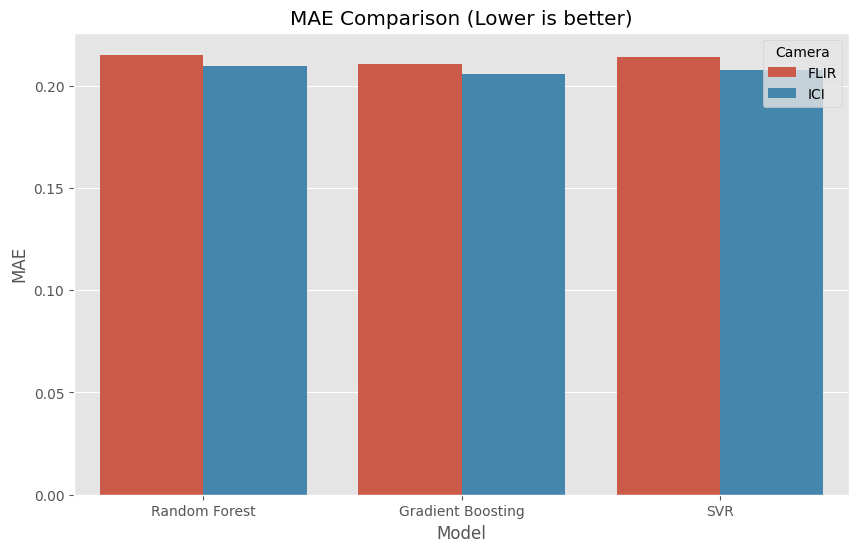

In [7]:
comparison_data = []
for name in flir_results:
    comparison_data.append({'Camera': 'FLIR', 'Model': name, **flir_results[name]})
for name in ici_results:
    comparison_data.append({'Camera': 'ICI', 'Model': name, **ici_results[name]})
    
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Bar Chart Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', hue='Camera', data=comparison_df)
plt.title('MAE Comparison (Lower is better)')
plt.show()

## 8. Final Recommendation and Conclusion

Based on the analysis above, we can determine which camera performs better.

In [8]:
best_flir = comparison_df[comparison_df['Camera'] == 'FLIR']['MAE'].min()
best_ici = comparison_df[comparison_df['Camera'] == 'ICI']['MAE'].min()

print(f"Best FLIR MAE: {best_flir:.4f}")
print(f"Best ICI MAE: {best_ici:.4f}")

if best_flir < best_ici:
    print("\nConclusion: FLIR provides better accuracy (lower MAE).")
else:
    print("\nConclusion: ICI provides better accuracy (lower MAE).")

Best FLIR MAE: 0.2104
Best ICI MAE: 0.2055

Conclusion: ICI provides better accuracy (lower MAE).
